<a target="_blank" href="https://colab.research.google.com/github/SLCFLAB/Fintech2025-2/blob/main/ML_day2/2_1_Regression_Penalty.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# ML_Day2_1

ref: https://github.com/codingalzi/handson-ml2/blob/master/notebooks/handson-ml2-04.ipynb

## 주요 내용

- Shirinkage Method, Model Legularization

## 기본 설정

- 필수 모듈 불러오기
- 그래프 출력 관련 기본 설정 지정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# 어레이 데이터를 csv 파일로 저장하기
def save_data(fileName, arrayName, header=''):
    np.savetxt(fileName, arrayName, delimiter=',', header=header, comments='')

## 규제를 사용하는 선형 모델

모델의 학습 과정에 규제를 가하는 방식으로 과대 적합을 감소시킬 수 있다.

선형 회귀 모델의 규제는 학습되는 일반적으로 파라미터에 제한을 두는 방식으로 이루어지며,
여기서는 다른 규제 방식이 적용된 세 모델을 소개한다.

* 릿지 회귀 (L2)
* 라쏘 회귀 (L1)
* 엘라스틱넷

### 릿지 회귀

아래 코드는 연습을 위해 1차 함수를 이용하여 20개의 훈련 데이터를 생성한다.

* `X`: 훈련 세트, 크기는 20.
* `X_new`: 100개의 검증용 데이터.

In [2]:
np.random.seed(42)

m = 20
X = 3 * np.random.rand(m, 1)                      # 0 이상 1 미만의 균일분포(uniform distribution)를 따르는 난수를 (m, 1) 모양의 배열로 생성
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5     # 1차 선형회귀 모델을 따로도록 함. 단, 잡음 추가됨.
X_new = np.linspace(0, 3, 100).reshape(100, 1)    # 0~3 구간에서 균등하게 100개의 검증 데이터 선택

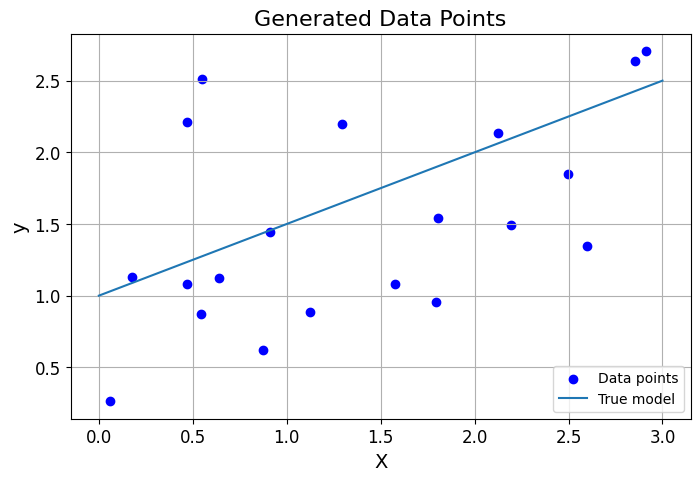

In [13]:
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', marker='o', label='Data points')
plt.xlabel("X", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.plot(X_new, 1 + 0.5 * X_new, label="True model")
plt.title("Generated Data Points", fontsize=16)
plt.grid(True)
plt.legend()
plt.show()

#### 릿지 회귀의 비용 함수

$$
\begin{align*}
J(\boldsymbol{\theta}) & = \text{MSE}(\boldsymbol{\theta}) + \dfrac{\alpha}{2}\sum\limits_{i=1}^{n}{\theta_i}^2 \\
& = \text{MSE}(\boldsymbol{\theta}) + \dfrac{\alpha}{2}\left (\theta_1^2 + \cdots + \theta_n^2 \right )
\end{align*}
$$

#### `Ridge` 모델

릿지 규제를 지원한다.

* `solver=cholesky`: 원래는 경사하강법을 계산하는 옵티마이저 지정. 
    하지만 `cholesky`를 지정하면 정규방정식(normal equation)을 이용하여 최적의 파라미터를 계산함.
* `alpha=1`: 규제 강도를 나타냄. 값이 클 수록 규제가 세짐. 이유는 비용 함숫값을 줄이기 위해
    $\theta_i$ 값들이 작아지도록 강요되기 때문임.

In [3]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([1.55071465])

* `solver=sag`: 경사하강법을 지원하는 다양한 옵티마이저 중에 하나임. 계속해서 보다 개선된 옵티마이저가 개발됨.

In [4]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([1.55072189])

아래 코드는 다양한 `alpha` 값의 영향력를 그래프로 보여준다.

오른편 그래프는 3개의 `alpha` 별로 Ridge 규제를 10차 다항 회귀 모델에 적용한 예시를 보여준다. 
`alpha`를 크게 할 수록 예측값의 그래프가 직선에 가까워짐을 볼 수 있다.

그림 저장: ridge_regression_plot


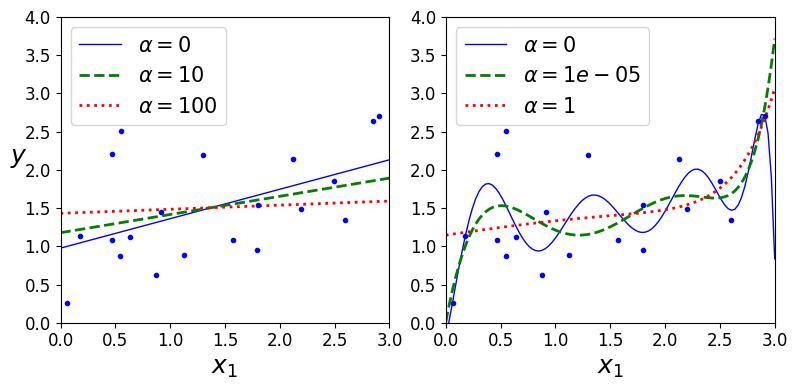

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)), # x, x^2, ..., x^10
                    ("std_scaler", StandardScaler()),           # 표준화 축척 조정
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

### 라쏘 회귀

#### 라쏘 회귀의 비용 함수

$$
\begin{align*}
J(\boldsymbol{\theta}) & = \text{MSE}(\boldsymbol{\theta}) + \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right| \\
& = \text{MSE}(\boldsymbol{\theta}) + \alpha \left (\, \left| \theta_1 \right| + \cdots + \left| \theta_n \right|\, \right )
\end{align*}
$$

#### `Lasso` 모델

라쏘 규제를 지원한다.

* `alpha=0.1`

__참고:__ 릿지 회귀에 사용된 `alpha` 값보다 작은 값을 사용하였다. 
이유는 릿지 회귀는 파라미터를 제곱해서 사용하는 반면에 라쏘 회귀에서는 파라미터의 절댓값을 사용하기 때문에
`alpha`가 작더라도 규제에 큰 영향을 주기 때문이다.

In [6]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

아래 코드는 라쏘 규제에 사용되는 다양한 `alpha` 값의 영향을 비교해준다.

오른편 그래프는 10차 다항회귀에 적용된 라쏘 회귀 모델의 예측값을 보여준다.
10차 다항 회귀라 하더라도 규제를 세개 주면 마치 3차 다항회귀를 준 것처럼 작동하게 함을 잘 보여준다.

d:\anaconda3\envs\reflective_allocator\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.803e+00, tolerance: 9.295e-04
  model = cd_fast.enet_coordinate_descent(


그림 저장: lasso_regression_plot


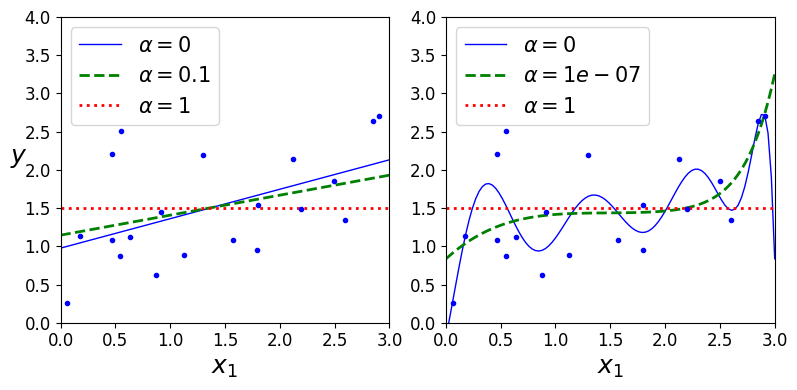

In [7]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

### 엘라스틱넷

릿지 회귀와 라쏘 회귀의 절충 모델을 지원한다.

#### 엘라스틱넷 비용 함수

$$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + r \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right| + \dfrac{1 - r}{2} \alpha \sum\limits_{i=1}^{n}{{\theta_i}^2}
$$

#### `ElasticNet` 모델

엘라스틱넷을 지원한다.

* `alpha=0.1`: 규제 강도
* `l1_ratio=0.5`: 혼합 비율 $r$을 가리킴.

In [8]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

아래 코드는 라쏘 회귀와 릿지 회귀, 엘라스틱넷 모델 학습 과정 동안 경사 하강법이 적용될 때
파라미터가 움직이는 특성을 비교해서 보여주기 위한 코드이다.

핵심은 다음과 같다.

- 첫 번째 행 왼편: $\ell_1$ 노름의 그레이디언트 벡터의 움직임. 
    $\theta_2$처럼 파라미터 값이 작을 수록 먼저 0에 수렴하는 것이 보여짐.
    훈련 과정에서는 별로 중요하지 않은 속성을 빠르게 무시하는 효과를 보여줌.
- 첫 번째 행 오른편: $\ell_1$ 노름이 추가된 평균 제곱 오차(MSE) 함수의 그레이디언트 벡터 움직임.
    $\theta_2$가 먼저 줄어드는 것을 잘 보여줌.
    전역 최저점에 근처에서 진동함. 이유는 절댓값의 미분이 0에서 정의되어 있지 않기 때문임.
- 두 번째 행 왼편: $\ell_2$ 노름의 그레이디언트 벡터 움직임. 
    모든 파라미터가 원점에 직선으로 달려가는 형태로 줄어듬.
- 두 번째 행 오른편: $\ell_2$ 노름이 추가된 평균 제곱 오차(MSE) 함수의 그레이디언트 벡터 움직임.
    파라미터가 전역 최저점 근처에서 느려짐. 이유는 그레이디언트가 작아지기 때문임.
- 세 번째 행 왼편: ElasticNet(ℓ₁+ℓ₂) 페널티가 적용된 그레이디언트 벡터의 움직임.
    ℓ₁의 각진 축 수렴과 ℓ₂의 원형 수렴이 결합된 형태로, 약간 깎인 다이아몬드 위를 따라 궤적이 형성됨.
- 세 번째 행 오른편: ElasticNet 페널티가 추가된 평균 제곱 오차(MSE) 함수의 그레이디언트 벡터 움직임.
    ℓ₁로 일부 파라미터가 빠르게 0으로, ℓ₂로 나머지는 부드럽게 전역 최소점으로 수렴하며 전역 최소점 부근에서 속도가 감속됨.

In [9]:
# 도표에 사용되는 좌표값 모음
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

그림 저장: lasso_ridge_elasticnet_plot


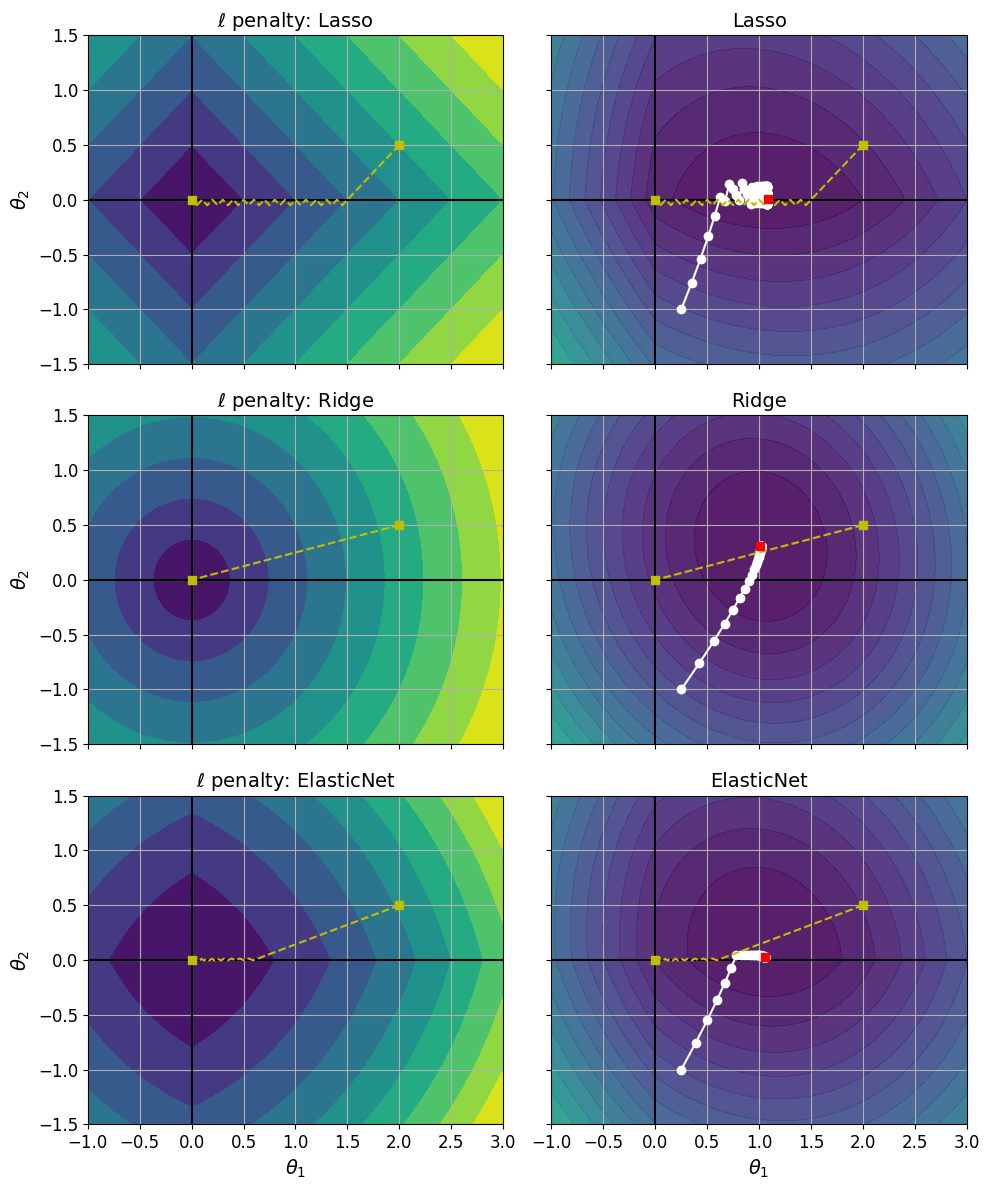

In [11]:
# 파라미터(theta) 경로 기억 어레이 생성 함수
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

# 1) 서브플롯을 3×2로
fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(10, 12))

# 2) Lasso, Ridge, ElasticNet 설정 리스트에 추가
#    (i, N, l1,   l2,    title)
configs = [
    (0, N1, 2.0, 0.0,   "Lasso"),
    (1, N2, 0.0, 2.0,   "Ridge"),
    # Elastic Net: l1=1.0, l2=1.0 (예시 — α·L1 + (1−α)·L2^2 형태로 바꿔도 됩니다)
    (2, None, 1.0, 1.0, "ElasticNet")
]

for i, _, l1, l2, title in configs:
    # 3) Elastic Net용 penalty 항 계산
    if title == "ElasticNet":
        # N1, N2는 미리 계산된 |θ| 합, sqrt(θ1²+θ2²) 배열
        N_en = l1 * N1 + l2 * 0.5 * N2**2
        JR = J + N_en
        # 최솟값 위치
        tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
        t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]
    else:
        # 기존 방식
        N = _      # Lasso→N1, Ridge→N2
        JR = J + l1 * N1 + l2 * 0.5 * N2**2
        tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
        t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    # 등고선 레벨
    levelsN = np.linspace(0, np.max(N if title!="ElasticNet" else N_en), 10)
    levelsJR = (np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)

    # 경사하강법 경로
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    # 순수 페널티 항 경사하강 (core=0)
    path_N  = bgd_path(np.array([[2.0], [0.5]]), Xr, yr,
                       np.sign(l1)/3 if title=="ElasticNet" else np.sign(l1),
                       np.sign(l2)   if title=="ElasticNet" else np.sign(l2),
                       core=0)

    # (a) 좌측: penalty ℓ₁+ℓ₂ 등고선 & path_N
    ax = axes[i, 0]
    ax.grid(True); ax.axhline(0, color='k'); ax.axvline(0, color='k')
    ax.contourf(t1, t2,
                N if title!="ElasticNet" else N_en,
                levels=levelsN)
    ax.plot(path_N[:,0], path_N[:,1], "y--")
    ax.plot(0, 0, "ys"); ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell$ penalty: " + title, fontsize=14)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 2: ax.set_xlabel(r"$\theta_1$", fontsize=14)
    ax.set_ylabel(r"$\theta_2$", fontsize=14)

    # (b) 우측: cost+penalty JR 등고선 & path_JR
    ax = axes[i, 1]
    ax.grid(True); ax.axhline(0, color='k'); ax.axvline(0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:,0], path_JR[:,1], "w-o")
    ax.plot(path_N[:,0], path_N[:,1], "y--")
    ax.plot(0, 0, "ys"); ax.plot(t1_min, t2_min, "ys"); ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=14)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 2: ax.set_xlabel(r"$\theta_1$", fontsize=14)

# 4) 저장·출력
save_fig("lasso_ridge_elasticnet_plot")
plt.tight_layout()
plt.show()
